# Pré processamento

In [211]:
# Importando as bibliotecas e construindo o dataframe
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

In [212]:
# concatenando dois dataframes (um com fake news e outro com noticias verdadeiras)
fake_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/Fake.csv')
true_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/True.csv')
# adicionando coluna label, correspondente a veracidade da noticias (1 para verdadeiro e 0 para falsa)
fake_df['label'] = 0
true_df['label'] = 1

combined_df = pd.concat([fake_df, true_df], ignore_index=True)

combined_df.to_csv('Combined.csv', index=False)
combined_df.reset_index(drop=True,inplace=True)

# Criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia

In [215]:
# criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia
import re
# regex para substituir caracteres que não forem letras e números
regex = r'[^a-zA-Z0-9\s]'
combined_df['text'] = combined_df['text'].map(lambda x: re.sub(regex, '', x))
combined_df['num_of_words'] = combined_df['text'].map(lambda x: len(x.split()))
combined_df.head()

,title,text,subject,date,label,num_of_words,text_vector
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,492,[-0.08635634 0.16764247 0.40040964 -0.361500...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,305,[ 0.00671101 0.0081033 -0.20852128 -0.087897...
2,Sheriff David Clarke Becomes An Internet Joke...,On Friday it was revealed that former Milwauke...,News,"December 30, 2017",0,579,[-3.62045884e-01 -1.23025492e-01 -5.51379442e-...
3,Trump Is So Obsessed He Even Has Obama’s Name...,On Christmas day Donald Trump announced that h...,News,"December 29, 2017",0,441,[ 1.73586905e-02 2.04306096e-03 7.36115128e-...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,420,[-7.90192410e-02 4.73764718e-01 1.55274183e-...


# Criando nova coluna com texto vetorizado 

In [2]:
# Initialize the Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to vectorize the text
def vectorize_text(text):
    return model.encode(text)

# Apply the function to create a new column with vectorized text
combined_df['text_vector'] = combined_df['text'].apply(vectorize_text)

# Convert the list of vectors to a numpy array
vectors = np.vstack(combined_df['text_vector'].to_numpy())

# Build the FAISS index
dimension = vectors.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(vectors)
combined_df.to_csv('vectorized_texts.csv', index=False)

C:\Users\guiL6\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


NameError: name 'combined_df' is not defined

In [214]:
combined_df = pd.read_csv('vectorized_texts.csv')
combined_df.head()

,title,text,subject,date,label,num_of_words,text_vector
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,492,[-0.08635634 0.16764247 0.40040964 -0.361500...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,305,[ 0.00671101 0.0081033 -0.20852128 -0.087897...
2,Sheriff David Clarke Becomes An Internet Joke...,On Friday it was revealed that former Milwauke...,News,"December 30, 2017",0,579,[-3.62045884e-01 -1.23025492e-01 -5.51379442e-...
3,Trump Is So Obsessed He Even Has Obama’s Name...,On Christmas day Donald Trump announced that h...,News,"December 29, 2017",0,441,[ 1.73586905e-02 2.04306096e-03 7.36115128e-...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,420,[-7.90192410e-02 4.73764718e-01 1.55274183e-...


In [4]:
# Function to find the most similar texts
def find_similar_texts(query_vector, k=2):
    distances, indices = index.search(np.array([query_vector]), k)
    return distances[0], indices[0]

# Example usage: compare the first text with the rest
query_vector = combined_df['text_vector'][0]
distances, indices = find_similar_texts(query_vector, k=len(combined_df))

# Output the results
print("Query text:", combined_df['text'][0])
print("\nMost similar texts:")
for i, (distance, idx) in enumerate(zip(distances, indices)):
    print(f"{i+1}. Text: {combined_df['text'][idx]} (Distance: {distance})")

NameError: name 'index' is not defined

# Setando campos como categóricos

In [216]:
combined_df.dtypes

title           object
text            object
subject         object
date            object
label            int64
num_of_words     int64
text_vector     object
dtype: object

In [217]:
combined_df['subject'] = combined_df['subject'].astype('category')
combined_df['date'] = combined_df['date'].astype('category')

In [218]:
combined_df.dtypes

title             object
text              object
subject         category
date            category
label              int64
num_of_words       int64
text_vector       object
dtype: object

In [219]:
combined_df['subject'] = combined_df['subject'].cat.codes
combined_df['date'] = combined_df['date'].cat.codes

In [220]:
combined_df.dtypes

title           object
text            object
subject           int8
date             int16
label            int64
num_of_words     int64
text_vector     object
dtype: object

# Verificando valores nulos e vazios

In [221]:
# verificando valores nulo
combined_df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
dtype: int64

In [222]:
# verificando valores vazios de titulo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['title'] = empty_values['title'] == ''
len(empty_values[empty_values['title'] == True])

0

In [223]:
# verificando valores vazios de texto
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['text'] = empty_values['text'] == ''
len(empty_values[empty_values['text'] == True])

631

In [224]:
# verificando valores vazios de tipo de conteúdo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['subject'] = empty_values['subject'] == ''
len(empty_values[empty_values['subject'] == True])

0

In [225]:
# setando valores num_of_words iguais a 0 para nulo
df = combined_df
df['num_of_words'] = df['num_of_words'].map(lambda x: np.nan if x == 0 else x)
df['num_of_words'].isnull().sum()

631

# Dividindo o dataset em batches para otimizar o uso do algoritmo KNN  

In [226]:
batch_size = 5000
df_numpy = df.to_numpy()

# Embaralhar os dados,
np.random.shuffle(df_numpy)
# Dividir o dataset em batches,
n_batches = int(np.ceil(df_numpy.shape[0] / batch_size))  # Número de batches
batches = np.array_split(df_numpy, n_batches)
batches_df = [pd.DataFrame(batch, columns=df.columns) for batch in batches]
df = pd.DataFrame(df_numpy, columns=df.columns)

for batch in batches_df:
    print(batch.isnull().sum())

title            0
text             0
subject          0
date             0
label            0
num_of_words    69
text_vector      0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    64
text_vector      0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    83
text_vector      0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    70
text_vector      0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    58
text_vector      0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    76
text_vector      0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    71
text_vecto

In [227]:
imputer = KNNImputer(n_neighbors=3)
df_num_of_words_knn = [pd.DataFrame(imputer.fit_transform(batch[['subject', 'date', 'num_of_words', 'label']]), columns=df[['subject', 'date', 'num_of_words', 'label']].columns) for batch in batches_df]


In [228]:
df_concatened = pd.DataFrame()
for batch in df_num_of_words_knn:
    df_concatened = pd.concat([df_concatened, batch], ignore_index=True)
    print(batch.isnull().sum())

subject         0
date            0
num_of_words    0
label           0
dtype: int64
subject         0
date            0
num_of_words    0
label           0
dtype: int64
subject         0
date            0
num_of_words    0
label           0
dtype: int64
subject         0
date            0
num_of_words    0
label           0
dtype: int64
subject         0
date            0
num_of_words    0
label           0
dtype: int64
subject         0
date            0
num_of_words    0
label           0
dtype: int64
subject         0
date            0
num_of_words    0
label           0
dtype: int64
subject         0
date            0
num_of_words    0
label           0
dtype: int64
subject         0
date            0
num_of_words    0
label           0
dtype: int64


In [229]:
df['num_of_words'] = df_concatened['num_of_words']
df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
dtype: int64

# Normalização

In [230]:
df

,title,text,subject,date,label,num_of_words,text_vector
0,Factbox: Trump on Twitter (September 8) - Hurr...,The following statements were posted to the ve...,6,2387,1,167.0,[-2.30017886e-01 9.78440568e-02 4.11018729e-...
1,Senate diverges over renewal of internet spyin...,WASHINGTON Reuters A Senate panel on Tuesday ...,6,2125,1,522.0,[-1.60385638e-01 -1.20772570e-01 -3.77683610e-...
2,FILMMAKER DINESH D’SOUZA: Eight Things I LOVE ...,FILMMAKER DINESH D SOUZA S Eight things I LOVE...,0,1065,0,953.0,[ 2.76459605e-01 -1.90681577e-01 -3.13233405e-...
3,DEMOCRAT ACCUSED Of Sexual Harassment Just Thr...,John Conyers might just drain the swamp for us...,4,1811,0,253.0,[ 0.00484835 -0.15543959 0.0336613 0.061070...
4,Wikileaks: NSA Spied on UN Secretary-General a...,InverseWikileaks released tonight a new cache...,1,760,0,229.0,[-4.13807601e-01 -9.08768699e-02 -2.11946428e-...
...,...,...,...,...,...,...,...
44893,Strong typhoon nears southern Japan the day be...,TOKYO Reuters Heavy rain and powerful winds a...,7,2113,1,200.0,[-0.28669474 -0.11136016 0.17992833 0.136761...
44894,People Are Now Hilariously Trolling Marco Rub...,Marco Rubio sounded so robotic during the last...,2,806,0,370.0,[-1.06461741e-01 -6.87992498e-02 -2.99810380e-...
44895,Syrian government forces press attack in east ...,ALEPPO SyriaBEIRUT Reuters The Syrian army pr...,6,640,1,1169.0,[-0.1370549 0.38019103 -0.03336731 -0.560238...
44896,Republican Collins' call for Garland hearings ...,WASHINGTON Reuters A moderate Republican sena...,6,196,1,416.0,[-1.62604362e-01 1.08115099e-01 -1.71974190e-...


In [231]:
# nomarlizando entre 0 e 1 min-max usando scikit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
df['subject_norm'] = scaler.fit_transform(df[['subject']])
df['num_of_words_norm'] = scaler.fit_transform(df[['num_of_words']])
df['date_norm'] = scaler.fit_transform(df[['date']])
df.head()

,title,text,subject,date,label,num_of_words,text_vector,subject_norm,num_of_words_norm,date_norm
0,Factbox: Trump on Twitter (September 8) - Hurr...,The following statements were posted to the ve...,6,2387,1,167.0,[-2.30017886e-01 9.78440568e-02 4.11018729e-...,0.857143,0.020441,0.996244
1,Senate diverges over renewal of internet spyin...,WASHINGTON Reuters A Senate panel on Tuesday ...,6,2125,1,522.0,[-1.60385638e-01 -1.20772570e-01 -3.77683610e-...,0.857143,0.064155,0.886895
2,FILMMAKER DINESH D’SOUZA: Eight Things I LOVE ...,FILMMAKER DINESH D SOUZA S Eight things I LOVE...,0,1065,0,953.0,[ 2.76459605e-01 -1.90681577e-01 -3.13233405e-...,0.000000,0.117227,0.444491
3,DEMOCRAT ACCUSED Of Sexual Harassment Just Thr...,John Conyers might just drain the swamp for us...,4,1811,0,253.0,[ 0.00484835 -0.15543959 0.0336613 0.061070...,0.571429,0.031031,0.755843
4,Wikileaks: NSA Spied on UN Secretary-General a...,InverseWikileaks released tonight a new cache...,1,760,0,229.0,[-4.13807601e-01 -9.08768699e-02 -2.11946428e-...,0.142857,0.028075,0.317195


In [232]:
df['subject_norm'].describe()

count    44898.000000
mean         0.674274
std          0.293159
min          0.000000
25%          0.285714
50%          0.714286
75%          0.857143
max          1.000000
Name: subject_norm, dtype: float64

In [233]:
df['num_of_words_norm'].describe()

count    44898.000000
mean         0.050275
std          0.042866
min          0.000000
25%          0.025982
50%          0.044699
75%          0.063170
max          1.000000
Name: num_of_words_norm, dtype: float64

In [234]:
df['date_norm'].describe()

count    44898.000000
mean         0.556596
std          0.294868
min          0.000000
25%          0.291319
50%          0.595159
75%          0.816361
max          1.000000
Name: date_norm, dtype: float64

# Discretização

In [235]:
# discretizando com 10 bins com mesmo intervalo
df['num_of_words_dist'] = pd.cut(df['num_of_words'], 10)

In [236]:
df['num_of_words_dist'].value_counts()

num_of_words_dist
(-7.121, 813.1]     41535
(813.1, 1625.2]      3000
(1625.2, 2437.3]      202
(2437.3, 3249.4]       76
(3249.4, 4061.5]       44
(4061.5, 4873.6]       13
(4873.6, 5685.7]       12
(5685.7, 6497.8]        6
(6497.8, 7309.9]        6
(7309.9, 8122.0]        4
Name: count, dtype: int64

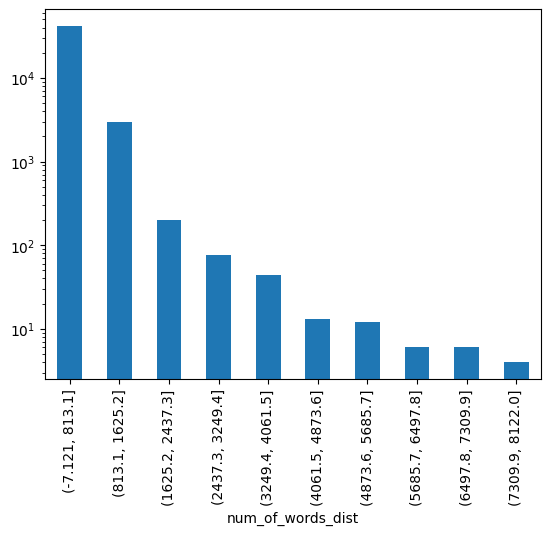

In [237]:
df['num_of_words_dist'].value_counts().plot(kind="bar")
plt.yscale("log")

# Detecção de outliers

In [238]:
# verificando duplicatas
df[df.duplicated()].head()

,title,text,subject,date,label,num_of_words,text_vector,subject_norm,num_of_words_norm,date_norm,num_of_words_dist
2021,"EU's Tusk says important to end ""devastation"" ...",WARSAW Reuters Poland is currently seen as a ...,7,574,1,102.0,[-0.55410135 0.5250697 0.1143855 0.149461...,1.0,0.012437,0.239566,"(-7.121, 813.1]"
3429,U.S. creating 'sensational hype' over China's ...,BEIJING Reuters The United States has created...,7,578,1,360.0,[-0.21992368 -0.17033483 -0.15842369 -0.240870...,1.0,0.044206,0.241235,"(-7.121, 813.1]"
3621,"Trump to host Norway's Solberg on Jan. 10, Whi...",WASHINGTON Reuters US President Donald Trump ...,7,599,1,72.0,[ 0.08668138 0.13443318 -0.28766903 -0.044817...,1.0,0.008743,0.250000,"(-7.121, 813.1]"
4387,British PM May vows to stay as party plotters ...,LONDON Reuters British Prime Minister Theresa...,7,2169,1,935.0,[ 0.31146264 -0.26915592 0.48046768 -0.068845...,1.0,0.115010,0.905259,"(813.1, 1625.2]"
4681,Lebanon detains Uber driver suspected of murde...,BEIRUT Reuters A Lebanese taxi driver with a ...,7,562,1,651.0,[ 0.17833523 0.12321828 -0.07681531 -0.286655...,1.0,0.080039,0.234558,"(-7.121, 813.1]"


In [239]:
df.drop_duplicates(keep = False, inplace = True)

In [240]:
df[df.duplicated()].head()

,title,text,subject,date,label,num_of_words,text_vector,subject_norm,num_of_words_norm,date_norm,num_of_words_dist


<Axes: >

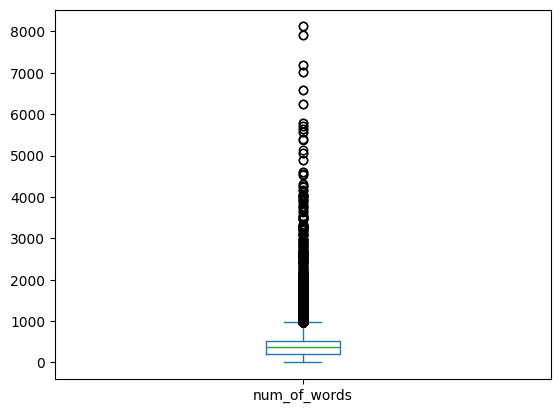

In [241]:
df = df[['title', 'text', 'subject','date', 'label', 'num_of_words', 'text_vector', 'subject_norm', 'num_of_words_norm', 'date_norm']]
df['num_of_words'].plot.box()

<Axes: ylabel='Frequency'>

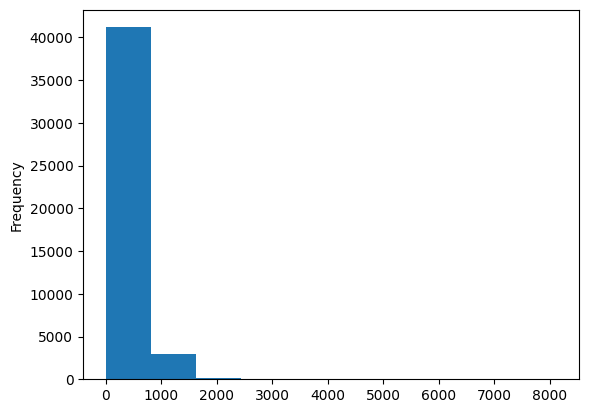

In [242]:
df['num_of_words'].plot.hist()

<Axes: ylabel='Frequency'>

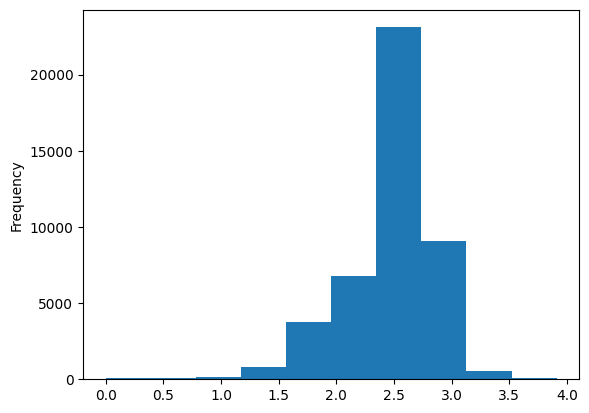

In [243]:
df['log_num_of_words'] = np.log10(df['num_of_words'])
df['log_num_of_words'].plot.hist()

In [244]:
mad = np.abs(df['log_num_of_words'] - df['log_num_of_words'].median()).median()*(1/0.6745)
print(mad)

0.26641272546257455


<Axes: >

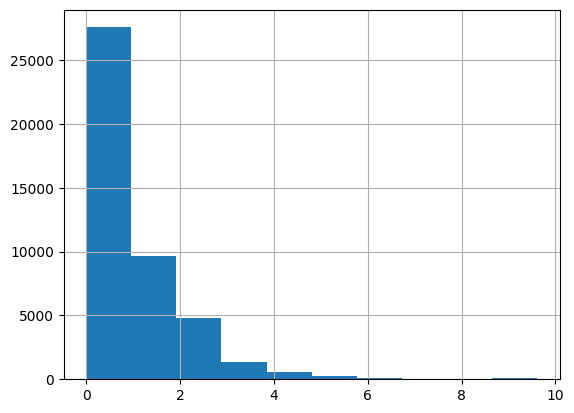

In [245]:
(np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad).hist()

In [246]:
df[np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad > 3.5]

,title,text,subject,date,label,num_of_words,text_vector,subject_norm,num_of_words_norm,date_norm,log_num_of_words
9,BLACK CHURCH WON’T ENDORSE CLINTON: “Like bein...,CNN s Carol Costello couldn t get the right an...,5,303,0,23.0,[-5.54868893e-04 -5.59009016e-01 -1.92451343e-...,0.714286,0.002709,0.126461,1.361728
44,“HILL”-ARIOUS VIDEO: HILLARY TAKES BREAK From ...,This video brilliantly dispels every one of Hi...,4,270,0,21.0,[-1.64356396e-01 -5.11336088e-01 -2.35366568e-...,0.571429,0.002463,0.112688,1.322219
73,HYSTERICAL! TRUMP TO GERMANY’S MERKEL on Obama...,Trump to Merkel on Obama s wiretapping at lea...,5,1432,0,21.0,[-1.63480684e-01 -5.31901196e-02 -4.06608321e-...,0.714286,0.002463,0.597663,1.322219
88,TRUMP CAMPAIGN MANAGER Nails Interview With Le...,Trump s new campaign manager took on Chuck Tod...,5,1263,0,27.0,[-3.23178172e-01 -1.92719139e-02 3.91115993e-...,0.714286,0.003202,0.527129,1.431364
115,BRAINIAC HILLARY SUPPORTER DESTROYS TRUMP’S Ho...,Via TMZ,5,2020,0,2.0,[-0.90766567 0.36254156 -0.52435106 -0.283168...,0.714286,0.000123,0.843072,0.301030
...,...,...,...,...,...,...,...,...,...,...,...
44743,Indonesia to reopen Bali airport after closure...,DENPASAR Indonesia Reuters Bali airport will ...,7,1932,1,38.0,[ 4.24368560e-01 -1.60492569e-01 2.25952640e-...,1.000000,0.004556,0.806344,1.579784
44793,[VIDEO] DINESH D’SOUZA Warned Us About What Th...,Dinesh made some frightening predictions in hi...,5,870,0,19.0,[ 8.31982121e-02 -1.22502856e-01 -8.81034285e-...,0.714286,0.002216,0.363105,1.278754
44839,BARBRA STREISAND AND CHRIS MATTHEWS ON TRUMP E...,BARBRA MOCKS TRUMP AT A CLINTON FUNDRAISER,5,817,0,7.0,[ 0.36852065 0.43543473 0.17067562 -0.211549...,0.714286,0.000739,0.340985,0.845098
44849,ANTI-TRUMP Protestors Prove They Have No Basis...,If ignorance is bliss the happiest people on e...,5,61,0,21.0,[ 0.02146763 0.18231401 -0.10336043 -0.195806...,0.714286,0.002463,0.025459,1.322219


In [247]:
len(df)

44493

In [250]:
df = df[abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad < 3.5]

In [251]:
len(df)

43053